# Using Ragas to Evaluate an Agent Application built with LangChain and LangGraph

In the following notebook, we'll be looking at how [Ragas](https://github.com/explodinggradients/ragas) can be helpful in a number of ways when looking to evaluate your RAG applications!

While this example is rooted in LangChain/LangGraph - Ragas is framework agnostic (you don't even need to be using a framework!).

We'll:

- Collect our data
- Create a simple Agent application
- Evaluate our Agent application

> NOTE: This notebook is modified from Ragas' Official Documentation [LangGraph tutorial](https://docs.ragas.io/en/stable/howtos/integrations/_langgraph_agent_evaluation/)!

## Installing Ragas and Other Dependencies
Install Ragas and Langgraph with pip:

In [ ]:
!pip install -qU langgraph==0.2.44 ragas==0.2.12 nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.1/415.1 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194

### Alpha Vantage API Key

Get free api key from https://www.alphavantage.co/support/#api-key

In [ ]:
import os
import getpass

os.environ["ALPHA_API_KEY"] = getpass.getpass("Enter your API key: ")

Enter your API key: ··········


## Building the ReAct Agent

### Define the get_stock_price Tool

The get_stock_price tool will be used by the agent to fetch the stock price of a specified company. We'll create this tool using the @tool decorator from LangChain.

In [ ]:
from langchain_core.tools import tool
import requests
import pandas as pd


@tool
def get_stock_price(ticker: str):
    """
    Fetches the stock price for a given ticker symbol using the Alpha Vantage API.

    Args:
        ticker (str): The ticker symbol of the stock.

    Returns:
        pd.DataFrame: A dataframe containing the latest stock data with 30min interval.
    """
    # Define your Alpha Vantage API key
    alpha_api_key = os.environ.get("ALPHA_API_KEY")

    # Construct the API request URL
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={ticker}&interval=30min&outputsize=full&apikey={alpha_api_key}'
    response = requests.get(url)
    data = response.json()

    # Check if the response contains the 'Time Series (30min)' key
    if 'Time Series (30min)' not in data:
        return f"Error: {data.get('Note', 'Unable to fetch data.')}"

    # Extract the time series data
    time_series = data['Time Series (30min)']

    # Convert the time series data into a DataFrame
    df = pd.DataFrame.from_dict(time_series, orient='index')

    # Rename the columns
    df.columns = ['open', 'high', 'low', 'close', 'volume']

    # Convert the index to datetime format
    df.index = pd.to_datetime(df.index)

    # Filter for the latest date
    latest_date = df.index.max().date()
    filtered_df = df[df.index.date == latest_date]

    return filtered_df



@tool
def calculate_percentage(stock_price: float, percentage: float) -> float:
    """
    Calculates the specified percentage of the given stock price.

    Args:
        stock_price (float): The current stock price.
        percentage (float): The percentage to calculate.

    Returns:
        float: The calculated percentage value of the stock price.
    """
    calculated_value = (percentage / 100) * stock_price
    return calculated_value

### Binding the Tool to the LLM
With the get_stock_price tool defined, the next step is to bind it to the AzureChatOpenAI model. This enables the agent to invoke the tool during its execution based on the user's requests allowing it to interact with external data and perform actions beyond its native capabilities.

In [ ]:
import json

with open ('config1_api.json') as f:
    cred1 = json.load(f)

In [ ]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    api_key=cred1['AZURE_OPENAI_KEY'],
    azure_endpoint=cred1['AZURE_OPENAI_ENDPOINT'],
    api_version=cred1['AZURE_OPENAI_APIVERSION'],
    model=cred1['CHATGPT_MODEL'],
    temperature=0
)

tools = [get_stock_price, calculate_percentage]
llm_with_tools = llm.bind_tools(tools)

In LangGraph, state plays a crucial role in tracking and updating information as the graph executes. As different parts of the graph run, the state evolves to reflect the changes and contains information that is passed between nodes.

For example, in a conversational system like this one, the state is used to track the exchanged messages. Each time a new message is generated, it is added to the state and the updated state is passed through the nodes, ensuring the conversation progresses logically.

### Defining the State
To implement this in LangGraph, we define a state class that maintains a list of messages. Whenever a new message is produced it gets appended to this list, ensuring that the conversation history is continuously updated.

In [ ]:
from langgraph.graph import END
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

### Defining the should_continue Function
The `should_continue` function determines whether the conversation should proceed with further tool interactions or end. Specifically, it checks if the last message contains any tool calls (e.g., a request for stock prices).

- If the last message includes tool calls, indicating that the agent has invoked an external tool, the conversation continues and moves to the "tools" node.
- If there are no tool calls, the conversation ends, represented by the END state.

In [ ]:
# Define the function that determines whether to continue or not
def should_continue(state: GraphState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

### Calling the Model
The `call_model` function interacts with the Language Model (LLM) to generate a response based on the current state of the conversation. It takes the updated state as input, processes it and returns a model-generated response.

In [ ]:
# Define the function that calls the model
def call_model(state: GraphState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

### Creating the Assistant Node
The `assistant` node is a key component responsible for processing the current state of the conversation and using the Language Model (LLM) to generate a relevant response. It evaluates the state, determines the appropriate course of action, and invokes the LLM to produce a response that aligns with the ongoing dialogue.

In [ ]:
# Node
def assistant(state: GraphState):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

### Creating the Tool Node
The `tool_node` is responsible for managing interactions with external tools, such as fetching stock prices or performing other actions beyond the LLM's native capabilities. The tools themselves are defined earlier in the code, and the tool_node invokes these tools based on the current state and the needs of the conversation.

In [ ]:
from langgraph.prebuilt import ToolNode

# Node
tools = [get_stock_price, calculate_percentage]
tool_node = ToolNode(tools)

### Building the Graph
The graph structure is the backbone of the agentic workflow, consisting of interconnected nodes and edges. To construct this graph, we use the StateGraph builder which allows us to define and connect various nodes. Each node represents a step in the process (e.g., the assistant node, tool node) and the edges dictate the flow of execution between these steps.

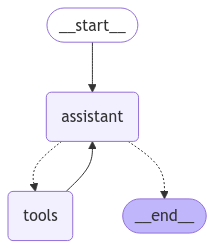

In [ ]:
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

# Define a new graph for the agent
builder = StateGraph(GraphState)

# Define the two nodes we will cycle between
builder.add_node("assistant", assistant)
builder.add_node("tools", tool_node)

# Set the entrypoint as `agent`
builder.add_edge(START, "assistant")

# Making a conditional edge
# should_continue will determine which node is called next.
builder.add_conditional_edges("assistant", should_continue, ["tools", END])

# Making a normal edge from `tools` to `agent`.
# The `agent` node will be called after the `tool`.
builder.add_edge("tools", "assistant")

# Compile and display the graph for a visual overview
react_graph = builder.compile()
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

To test our setup, we will run the agent with a query. The agent will fetch the stock price of Apple company using the Alpha API key.

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    HumanMessage(
        content="What is the current stock price of Apple?"
    )
]

result = react_graph.invoke({"messages": messages})

In [ ]:
result["messages"]

[HumanMessage(content='What is the current stock price of Apple?', additional_kwargs={}, response_metadata={}, id='705aff3e-ad1b-43db-b317-5a9620722b9e'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5rXSWEHSYI9qlBl9WDmTVvyu', 'function': {'arguments': '{"ticker":"AAPL"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 159, 'total_tokens': 175, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b705f0c291', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filt

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    HumanMessage(
        content="Can you tell me what is 25 percent of current stock price of Apple?"
    )
]

result = react_graph.invoke({"messages": messages})

In [ ]:
result["messages"]

[HumanMessage(content='Can you tell me what is 25 percent of current stock price of Apple?', additional_kwargs={}, response_metadata={}, id='8184e7fe-a31e-40a0-8a4c-89f7f6111643'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_floLklDUGWcJvCqrjytUea9v', 'function': {'arguments': '{"ticker":"AAPL"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 166, 'total_tokens': 182, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b705f0c291', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity':

### Converting Messages to Ragas Evaluation Format

In the current implementation, the GraphState stores messages exchanged between the human user, the AI (LLM's responses), and any external tools (APIs or services the AI uses) in a list. Each message is an object in LangChain's format

```python
# Implementation of Graph State
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
```

Each time a message is exchanged during agent execution, it gets added to the messages list in the GraphState. However, Ragas requires a specific message format for evaluating interactions.

Ragas uses its own format to evaluate agent interactions. So, if you're using LangGraph, you will need to convert the LangChain message objects into Ragas message objects. This allows you to evaluate your AI agents with Ragas’ built-in evaluation tools.

**Goal:**  Convert the list of LangChain messages (e.g., HumanMessage, AIMessage, and ToolMessage) into the format expected by Ragas, so the evaluation framework can understand and process them properly.

To convert a list of LangChain messages into a format suitable for Ragas evaluation, Ragas provides the function [convert_to_ragas_messages][ragas.integrations.langgraph.convert_to_ragas_messages], which can be used to transform LangChain messages into the format expected by Ragas.

Here's how you can use the function:

In [ ]:
from ragas.integrations.langgraph import convert_to_ragas_messages

# Assuming 'result["messages"]' contains the list of LangChain messages
ragas_trace = convert_to_ragas_messages(result["messages"])

In [ ]:
ragas_trace  # List of Ragas messages

[HumanMessage(content='Can you tell me what is 25 percent of current stock price of Apple?', metadata=None, type='human'),
 AIMessage(content='', metadata=None, type='ai', tool_calls=[ToolCall(name='get_stock_price', args={'ticker': 'AAPL'})]),
 ToolMessage(content='                         open      high       low     close    volume\n2025-03-05 19:30:00  236.2200  236.2300  235.5000  235.7823      5520\n2025-03-05 19:00:00  235.7400  236.3900  235.7000  236.1100      5731\n2025-03-05 18:30:00  236.3700  236.3700  235.7000  235.7000     10454\n2025-03-05 18:00:00  236.1200  236.4100  236.0000  236.3700     17208\n2025-03-05 17:30:00  236.0699  236.3600  235.7400  236.1500     36303\n2025-03-05 17:00:00  236.0300  236.3200  236.0000  236.0300     19014\n2025-03-05 16:30:00  235.9000  250.5416  235.4065  236.0500    146315\n2025-03-05 16:00:00  235.7700  236.0000  234.0676  235.8700  15664371\n2025-03-05 15:30:00  236.0100  236.3900  235.0600  235.8200   3876091\n2025-03-05 15:00:00  23

## Evaluating the Agent's Performance

For this tutorial, let us evaluate the Agent with the following metrics:

- [Tool call Accuracy](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/agents/#tool-call-accuracy):ToolCallAccuracy is a metric that can be used to evaluate the performance of the LLM in identifying and calling the required tools to complete a given task.  

- [Agent Goal accuracy](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/agents/#agent-goal-accuracy): Agent goal accuracy is a metric that can be used to evaluate the performance of the LLM in identifying and achieving the goals of the user. This is a binary metric, with 1 indicating that the AI has achieved the goal and 0 indicating that the AI has not achieved the goal.
- [Topic Adherence](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/agents/): Topic adherence is a metric that can be used to ensure the Agent system is staying "on-topic", meaning that it's not straying from the intended use case. You can think of this as a kinda of faithfulness, where the responses of the LLM should stay faithful to the topic provided.


First, let us actually run our Agent with a couple of queries, and make sure we have the ground truth labels for these queries.

### Tool Call Accuracy

In [ ]:
from ragas.metrics import ToolCallAccuracy
from ragas.dataset_schema import MultiTurnSample
from ragas.integrations.langgraph import convert_to_ragas_messages
import ragas.messages as r


ragas_trace = convert_to_ragas_messages(
    messages=result["messages"]
)  # List of Ragas messages converted using the Ragas function

sample = MultiTurnSample(
    user_input=ragas_trace,
    reference_tool_calls=[
        r.ToolCall(name="get_stock_price", args={"ticker": "AAPL"}),
        r.ToolCall(name="calculate_percentage", args={"percentage": "25"})
    ],
)

tool_accuracy_scorer = ToolCallAccuracy()
tool_accuracy_scorer.llm = llm
await tool_accuracy_scorer.multi_turn_ascore(sample)

1.0

Tool Call Accuracy: 1, because the LLM correctly identified and used the necessary tool (get_stock_price) with the correct parameters (i.e., ticker as "AAPL").

### Agent Goal Accuracy

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    SystemMessage(
        content="You are a stock price assistant. Fetch the company ticker and get stock details for the user."
    ),
    HumanMessage(
        content="What is the current stock price of Nvidia?"
    )
]

result = react_graph.invoke({"messages": messages})

In [ ]:
result["messages"]  # List of Langchain messages

[SystemMessage(content='You are a stock price assistant. Fetch the company ticker and get stock details for the user.', additional_kwargs={}, response_metadata={}, id='a5840cb8-94b5-4d0b-9a67-0c42d0d96902'),
 HumanMessage(content='What is the current stock price of Nvidia?', additional_kwargs={}, response_metadata={}, id='c14cdb04-a233-416a-ab6f-8c94a355b7ef'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wvQ7eaZhhCpO6ZBtPHfpt5Kc', 'function': {'arguments': '{"ticker":"NVDA"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 115, 'total_tokens': 131, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b705f0c291', 'prompt_filter_results': [{'prompt_i

In [ ]:
from ragas.integrations.langgraph import convert_to_ragas_messages

ragas_trace = convert_to_ragas_messages(
    result["messages"]
)  # List of Ragas messages converted using the Ragas function
ragas_trace

[HumanMessage(content='What is the current stock price of Nvidia?', metadata=None, type='human'),
 AIMessage(content='', metadata=None, type='ai', tool_calls=[ToolCall(name='get_stock_price', args={'ticker': 'NVDA'})]),
 ToolMessage(content='                         open      high       low     close    volume\n2025-03-05 19:30:00  116.7700  116.8200  116.5000  116.5199    217187\n2025-03-05 19:00:00  116.6900  116.7900  116.6200  116.7800    151851\n2025-03-05 18:30:00  116.8200  116.8900  116.6400  116.6500    182270\n2025-03-05 18:00:00  116.7800  116.9300  116.6000  116.8300    224597\n2025-03-05 17:30:00  116.8850  117.3000  116.7800  116.8000   2721199\n2025-03-05 17:00:00  117.1991  117.2500  116.8300  116.9000    293319\n2025-03-05 16:30:00  117.3600  124.3559  108.8867  117.1801   1636443\n2025-03-05 16:00:00  117.2900  117.8500  114.8700  117.3799  45118075\n2025-03-05 15:30:00  117.6400  118.2090  117.1200  117.3000  20813010\n2025-03-05 15:00:00  117.5000  118.2781  116.760

In [ ]:
from ragas.dataset_schema import MultiTurnSample
from ragas.metrics import AgentGoalAccuracyWithReference
from ragas.llms import LangchainLLMWrapper


sample = MultiTurnSample(
    user_input=ragas_trace,
    reference="current stock price of Nvidia",
)

scorer = AgentGoalAccuracyWithReference()

evaluator_llm = LangchainLLMWrapper(llm)
scorer.llm = evaluator_llm
await scorer.multi_turn_ascore(sample)

1.0

Agent Goal Accuracy: 1, because the LLM correctly achieved the user’s goal of retrieving the stock price of Nvidia Company.

### Topic Adherence



In [ ]:
messages = [HumanMessage(content="How fast can an eagle fly?")]

result = react_graph.invoke({"messages": messages})

In [ ]:
result["messages"]

[HumanMessage(content='How fast can an eagle fly?', additional_kwargs={}, response_metadata={}, id='81234df5-411d-48a8-a056-fa3b4083dfa4'),
 AIMessage(content='Eagles are known for their impressive flying abilities. The speed of an eagle can vary depending on the species and the circumstances. Generally, eagles can fly at speeds ranging from 30 to 50 miles per hour (48 to 80 kilometers per hour) during level flight. However, when diving to catch prey, some eagles can reach speeds of over 100 miles per hour (160 kilometers per hour). The golden eagle, for example, is known for its remarkable diving speed.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 99, 'prompt_tokens': 94, 'total_tokens': 193, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', '

In [ ]:
from ragas.integrations.langgraph import convert_to_ragas_messages

ragas_trace = convert_to_ragas_messages(
    result["messages"]
)  # List of Ragas messages converted using the Ragas function
ragas_trace

[HumanMessage(content='How fast can an eagle fly?', metadata=None, type='human'),
 AIMessage(content='Eagles are known for their impressive flying abilities. The speed of an eagle can vary depending on the species and the circumstances. Generally, eagles can fly at speeds ranging from 30 to 50 miles per hour (48 to 80 kilometers per hour) during level flight. However, when diving to catch prey, some eagles can reach speeds of over 100 miles per hour (160 kilometers per hour). The golden eagle, for example, is known for its remarkable diving speed.', metadata=None, type='ai', tool_calls=[])]

In [ ]:
from ragas.metrics import TopicAdherenceScore

sample = MultiTurnSample(
    user_input=ragas_trace,
    reference_topics = ["stocks"]
)

evaluator_llm = LangchainLLMWrapper(llm)
scorer = TopicAdherenceScore(llm = evaluator_llm, mode="precision")
await scorer.multi_turn_ascore(sample)

0.0

As we can see, the current implementation fails due to talking about birds, when it should be talking about stocks!